In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

raw_prices = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Dados\Raw_prices.csv')
negocios = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Dados\Negocios.csv')
financeiro = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Dados\Financeiro.csv')
ibov = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Dados\Ibov_data.csv')

In [2]:
raw_prices['Datas'] = pd.to_datetime(raw_prices['Datas'])
precos_corte = raw_prices[(raw_prices['Datas'] >= '2000-01-01') & (raw_prices['Datas'] <= '2020-12-31')]
precos_corte.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5479 entries, 3652 to 9130
Columns: 1383 entries, Datas to ZIVI4
dtypes: datetime64[ns](1), float64(1382)
memory usage: 57.9 MB


In [3]:
long_data = precos_corte.melt(id_vars=['Datas'], var_name='Codigo', value_name='Preco')
long_data['Ano'] = long_data['Datas'].dt.year
long_data['Trimestre'] = long_data['Datas'].dt.quarter
long_data['Total_Dias_Negociacao'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Datas'].transform('nunique')
long_data['Pregoes'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Preco'].transform(lambda x: x.notna().sum())
long_data['Pregoes_Percentual'] = long_data['Pregoes'] / long_data['Total_Dias_Negociacao']
long_data = long_data[long_data['Pregoes_Percentual'] > 0.9]
long_data = long_data.reset_index(drop=True)
long_data['Preco'] = long_data['Preco'].fillna(method='ffill')
long_data['Retorno'] = long_data.groupby('Codigo')['Preco'].pct_change()
long_data['Risco'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: np.sqrt(len(x.dropna())) * np.nanstd(x, ddof=1))
long_data['Mean_Risco'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Risco'].transform(lambda x: x.mean(skipna=True))

In [4]:
long_data['Retornos_positivos'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Retorno'].transform(lambda x: (x > 0).sum())
long_data['Retornos_negativos'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Retorno'].transform(lambda x: (x < 0).sum())
long_data['Perc_positivos'] = long_data['Retornos_positivos'] / (long_data['Retornos_positivos'] + long_data['Retornos_negativos'])
long_data['Perc_negativos'] = long_data['Retornos_negativos'] / (long_data['Retornos_positivos'] + long_data['Retornos_negativos'])
long_data['Retorno'] = long_data['Retorno'].fillna(0)
long_data['Retorno_trimestral'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Retorno'].transform(lambda x: np.prod(1 + x) - 1)
long_data['Retorno_acumulado'] = long_data.groupby('Codigo')['Retorno'].transform(lambda x: (1 + x).cumprod() - 1)
long_data['FIP'] = long_data['Perc_negativos'] - long_data['Perc_positivos']

In [5]:
dados_agregados = long_data.groupby(['Codigo', 'Ano', 'Trimestre']).agg({'Retorno_trimestral':'first', 'Risco':'first', 'FIP':'first'})

In [6]:
dados_agregados['Decil_Retorno'] = dados_agregados.groupby(['Ano', 'Trimestre'])['Retorno_trimestral'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_Risco'] = dados_agregados.groupby(['Ano', 'Trimestre'])['Risco'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_FIP'] = dados_agregados.groupby(['Ano', 'Trimestre'])['FIP'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)

In [7]:
dados_agregados = dados_agregados.reset_index()

In [8]:
long_data = pd.merge(long_data, dados_agregados[['Codigo', 'Ano', 'Trimestre', 'Decil_Retorno', 'Decil_Risco', 'Decil_FIP']], on=['Codigo', 'Ano', 'Trimestre'], how='left')

In [9]:
long_data['Retorno_Medio'] = long_data.groupby(['Codigo', 'Ano', 'Trimestre'])['Retorno'].transform(lambda x: x.mean(skipna=True))

In [10]:
long_data

,Datas,Codigo,Preco,Ano,Trimestre,Total_Dias_Negociacao,Pregoes,Pregoes_Percentual,Retorno,Risco,...,Retornos_negativos,Perc_positivos,Perc_negativos,Retorno_trimestral,Retorno_acumulado,FIP,Decil_Retorno,Decil_Risco,Decil_FIP,Retorno_Medio
0,2008-01-01,ABCB4,NaN,2008,1,65,60,0.923077,0.000000,0.647118,...,34,0.423729,0.576271,-0.177697,0.000000,0.152542,6,5,6,-0.002702
1,2008-01-02,ABCB4,9.901598,2008,1,65,60,0.923077,0.000000,0.647118,...,34,0.423729,0.576271,-0.177697,0.000000,0.152542,6,5,6,-0.002702
2,2008-01-03,ABCB4,9.651906,2008,1,65,60,0.923077,-0.025217,0.647118,...,34,0.423729,0.576271,-0.177697,-0.025217,0.152542,6,5,6,-0.002702
3,2008-01-04,ABCB4,9.341943,2008,1,65,60,0.923077,-0.032114,0.647118,...,34,0.423729,0.576271,-0.177697,-0.056522,0.152542,6,5,6,-0.002702
4,2008-01-07,ABCB4,9.083640,2008,1,65,60,0.923077,-0.027650,0.647118,...,34,0.423729,0.576271,-0.177697,-0.082609,0.152542,6,5,6,-0.002702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068834,2008-06-24,ESTC11,52.237347,2008,2,65,62,0.953846,-0.019074,0.471044,...,22,0.645161,0.354839,1.515583,0.538846,-0.290323,10,2,1,0.015342
1068835,2008-06-25,ESTC11,52.548283,2008,2,65,62,0.953846,0.005952,0.471044,...,22,0.645161,0.354839,1.515583,0.548005,-0.290323,10,2,1,0.015342
1068836,2008-06-26,ESTC11,51.802036,2008,2,65,62,0.953846,-0.014201,0.471044,...,22,0.645161,0.354839,1.515583,0.526022,-0.290323,10,2,1,0.015342
1068837,2008-06-27,ESTC11,52.216618,2008,2,65,62,0.953846,0.008003,0.471044,...,22,0.645161,0.354839,1.515583,0.538235,-0.290323,10,2,1,0.015342


In [11]:
negocios['Datas'] = pd.to_datetime(negocios['Datas'])
negocios = negocios[(negocios['Datas'] >= '2000-01-01') & (negocios['Datas'] <= '2020-12-31')]
negocios = negocios.melt(id_vars='Datas', var_name='Codigo', value_name='Negocios')
negocios['Ano'] = negocios['Datas'].dt.year
negocios['Trimestre'] = negocios['Datas'].dt.quarter
negocios['Media_Negocios_Acao'] = negocios.groupby(['Codigo', 'Ano', 'Trimestre'])['Negocios'].transform(lambda x: x.mean(skipna=True))
negocios['Dias_Negocios'] = negocios.groupby(['Codigo', 'Ano'])['Negocios'].transform(lambda x: x.notna().sum())
dias_por_trimestre = negocios.groupby(['Ano', 'Trimestre'])['Datas'].nunique().rename('Total_Dias_Negociacao')
negocios = negocios.merge(dias_por_trimestre, on=['Ano', 'Trimestre'], how='left')
negocios['Negocios_Percentual'] = negocios['Dias_Negocios'] / negocios['Total_Dias_Negociacao']
negocios = negocios[negocios['Negocios_Percentual'] > 0.9] 
negocios['Medias_Negocios'] = negocios.groupby(['Ano', 'Trimestre'])['Negocios'].transform(lambda x: x.mean(skipna=True))
negocios['Razao_Media_Negocios'] = negocios['Media_Negocios_Acao'] / negocios['Medias_Negocios']

In [12]:
negocios_2 = negocios.groupby(['Codigo', 'Ano', 'Trimestre']).first().reset_index().drop(['Negocios'], axis=1)

In [13]:
financeiro['Datas'] = pd.to_datetime(financeiro['Datas'])
financeiro = financeiro[(financeiro['Datas'] >= '2000-01-01') & (financeiro['Datas'] <= '2020-12-31')]
financeiro = financeiro.melt(id_vars=['Datas'], var_name='Codigo', value_name='Financeiro')
financeiro['Ano'] = financeiro['Datas'].dt.year
financeiro['Trimestre'] = financeiro['Datas'].dt.quarter
financeiro['Media_Financeiro_Ativo_Trimestre'] = financeiro.groupby(['Codigo', 'Ano'])['Financeiro'].transform(lambda x: x.mean(skipna=True))
financeiro['Financeiro_Dias'] = financeiro.groupby(['Codigo', 'Ano', 'Trimestre'])['Financeiro'].transform(lambda x: x.notna().sum())
financeiro['Total_Financeiro_Dias'] = financeiro.groupby(['Codigo', 'Ano', 'Trimestre'])['Datas'].transform(lambda x: x.nunique())
financeiro['Financeiro_Dias_Percentual'] = financeiro['Financeiro_Dias'] / financeiro['Total_Financeiro_Dias']
financeiro = financeiro[financeiro['Financeiro_Dias_Percentual'] > 0.9]
financeiro['Media_Financeiro_Trimestre'] = financeiro.groupby(['Ano', 'Trimestre'])['Financeiro'].transform(lambda x: x.mean(skipna=True))
financeiro['DP_Financeiro_Trimestre'] = financeiro.groupby(['Ano', 'Trimestre'])['Financeiro'].transform(lambda x: x.std(skipna=True))
financeiro['Razao_Financeiro'] = financeiro['Media_Financeiro_Ativo_Trimestre'] / financeiro['Media_Financeiro_Trimestre']
financeiro_2 = financeiro.groupby(['Codigo', 'Ano', 'Trimestre']).first().reset_index().drop('Financeiro', axis=1)

In [14]:
df = long_data.merge(negocios_2, on=['Codigo', 'Ano', 'Trimestre'], how='left')
df = df.merge(financeiro_2)

In [15]:
df.columns

Index(['Datas_x', 'Codigo', 'Preco', 'Ano', 'Trimestre',
       'Total_Dias_Negociacao_x', 'Pregoes', 'Pregoes_Percentual', 'Retorno',
       'Risco', 'Mean_Risco', 'Retornos_positivos', 'Retornos_negativos',
       'Perc_positivos', 'Perc_negativos', 'Retorno_trimestral',
       'Retorno_acumulado', 'FIP', 'Decil_Retorno', 'Decil_Risco', 'Decil_FIP',
       'Retorno_Medio', 'Datas_y', 'Media_Negocios_Acao', 'Dias_Negocios',
       'Total_Dias_Negociacao_y', 'Negocios_Percentual', 'Medias_Negocios',
       'Razao_Media_Negocios', 'Datas', 'Media_Financeiro_Ativo_Trimestre',
       'Financeiro_Dias', 'Total_Financeiro_Dias',
       'Financeiro_Dias_Percentual', 'Media_Financeiro_Trimestre',
       'DP_Financeiro_Trimestre', 'Razao_Financeiro'],
      dtype='object')

In [16]:
df = df.drop(['Datas_y', 'Datas', 'Total_Dias_Negociacao_y'], axis=1).rename(columns={'Datas_x': 'Datas', 'Total_Dias_Negociacao_x':'Total_Dias_Negociacao'})

In [17]:
df

,Datas,Codigo,Preco,Ano,Trimestre,Total_Dias_Negociacao,Pregoes,Pregoes_Percentual,Retorno,Risco,...,Negocios_Percentual,Medias_Negocios,Razao_Media_Negocios,Media_Financeiro_Ativo_Trimestre,Financeiro_Dias,Total_Financeiro_Dias,Financeiro_Dias_Percentual,Media_Financeiro_Trimestre,DP_Financeiro_Trimestre,Razao_Financeiro
0,2008-01-01,ABCB4,NaN,2008,1,65,60,0.923077,0.000000,0.647118,...,3.830769,400.407582,0.114259,1668.837213,60,65,0.923077,21947.853037,80284.425184,0.076036
1,2008-01-02,ABCB4,9.901598,2008,1,65,60,0.923077,0.000000,0.647118,...,3.830769,400.407582,0.114259,1668.837213,60,65,0.923077,21947.853037,80284.425184,0.076036
2,2008-01-03,ABCB4,9.651906,2008,1,65,60,0.923077,-0.025217,0.647118,...,3.830769,400.407582,0.114259,1668.837213,60,65,0.923077,21947.853037,80284.425184,0.076036
3,2008-01-04,ABCB4,9.341943,2008,1,65,60,0.923077,-0.032114,0.647118,...,3.830769,400.407582,0.114259,1668.837213,60,65,0.923077,21947.853037,80284.425184,0.076036
4,2008-01-07,ABCB4,9.083640,2008,1,65,60,0.923077,-0.027650,0.647118,...,3.830769,400.407582,0.114259,1668.837213,60,65,0.923077,21947.853037,80284.425184,0.076036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068834,2008-06-24,ESTC11,52.237347,2008,2,65,62,0.953846,-0.019074,0.471044,...,1.984615,432.368402,0.218265,2689.104938,62,65,0.953846,21002.463391,86867.272576,0.128038
1068835,2008-06-25,ESTC11,52.548283,2008,2,65,62,0.953846,0.005952,0.471044,...,1.984615,432.368402,0.218265,2689.104938,62,65,0.953846,21002.463391,86867.272576,0.128038
1068836,2008-06-26,ESTC11,51.802036,2008,2,65,62,0.953846,-0.014201,0.471044,...,1.984615,432.368402,0.218265,2689.104938,62,65,0.953846,21002.463391,86867.272576,0.128038
1068837,2008-06-27,ESTC11,52.216618,2008,2,65,62,0.953846,0.008003,0.471044,...,1.984615,432.368402,0.218265,2689.104938,62,65,0.953846,21002.463391,86867.272576,0.128038


In [18]:
ibovespa = ibov.copy()
ibovespa['Datas'] = pd.to_datetime(ibovespa['Datas'])
ibovespa['Ano'] = ibovespa['Datas'].dt.year
ibovespa['Trimestre'] = ibovespa['Datas'].dt.quarter
ibovespa = ibovespa[(ibovespa['Datas'] >= '2000-01-01') & (ibovespa['Datas'] <= '2020-12-31')]
ibovespa['Pontos'] = ibovespa['Pontos'].fillna(method='ffill')
ibovespa['Retorno'] = ibovespa['Pontos'].pct_change()
ibovespa['Retorno'] = ibovespa['Retorno'].fillna(0)
ibovespa['Retorno_trimestre'] = ibovespa.groupby(['Ano', 'Trimestre'])['Retorno'].transform(lambda x: np.prod(1 + x) - 1)
ibovespa = ibovespa.reset_index(drop=True)

In [19]:
ibovespa

,Datas,Pontos,Ano,Trimestre,Retorno,Retorno_trimestre
0,2000-01-03,16930.00,2000,1,0.000000,0.052569
1,2000-01-04,15851.00,2000,1,-0.063733,0.052569
2,2000-01-05,16245.00,2000,1,0.024856,0.052569
3,2000-01-06,16106.00,2000,1,-0.008556,0.052569
4,2000-01-07,16309.00,2000,1,0.012604,0.052569
...,...,...,...,...,...,...
5474,2020-12-25,117806.85,2020,4,0.000000,0.258065
5475,2020-12-28,119123.70,2020,4,0.011178,0.258065
5476,2020-12-29,119409.15,2020,4,0.002396,0.258065
5477,2020-12-30,119017.24,2020,4,-0.003282,0.258065


In [20]:
df_filtrado = df[(df['Razao_Financeiro'] > 0.05) & (df['Razao_Media_Negocios'] > 0.01)]

In [21]:
lista_dfs = [grupo.reset_index(drop=True) for _, grupo in df_filtrado.groupby(['Ano', 'Trimestre'])]

In [22]:
Lista_Carteira_Mercado = []

for df in lista_dfs:
    agrupado = df.groupby('Codigo').agg(
        {
        'Risco':'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }
    ).reset_index()
    Lista_Carteira_Mercado.append(agrupado)

In [23]:
Lista_Carteira_Mercado[0]

,Codigo,Risco,Retorno_trimestral,Decil_Retorno,Decil_Risco,Ano,Trimestre
0,ACES3,0.559744,0.285122,8.0,7.0,2000.0,1.0
1,ACES4,0.562000,0.101438,7.0,7.0,2000.0,1.0
2,AMBV4,0.460714,0.033885,6.0,5.0,2000.0,1.0
3,ARCE3,0.273894,0.045390,6.0,1.0,2000.0,1.0
4,ARCE4,0.540562,0.203176,8.0,7.0,2000.0,1.0
...,...,...,...,...,...,...,...
110,VIVO3,0.604020,0.610531,10.0,8.0,2000.0,1.0
111,VIVO4,0.656666,0.330326,9.0,8.0,2000.0,1.0
112,VIVT3,0.471795,0.259612,8.0,5.0,2000.0,1.0
113,VIVT4,0.508543,0.233703,8.0,6.0,2000.0,1.0


In [24]:
lista_carteira_1 = []
lista_carteira_2 = []
lista_carteira_3 = []
lista_carteira_4 = []
lista_carteira_5 = []
lista_carteira_low = []

for df in lista_dfs:
    
    # Para a carteira 1
    filtrado_1 = df[df['Decil_Risco'] <= 1]
    agregado_1 = filtrado_1.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }).reset_index()
    lista_carteira_1.append(agregado_1)
        
    # Para a carteira 2    
    filtrado_2 = df[(df['Decil_Risco'] <= 2) & (df['Decil_Risco'] > 1)]
    agregado_2 = filtrado_2.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }).reset_index()
    lista_carteira_2.append(agregado_2)
    
    # Para a carteira 3
    filtrado_3 = df[(df['Decil_Risco'] <= 3) & (df['Decil_Risco'] > 2)]
    agregado_3 = filtrado_3.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }).reset_index()
    lista_carteira_3.append(agregado_3)
    
    # Para a carteira 4
    filtrado_4 = df[(df['Decil_Risco'] <= 4) & (df['Decil_Risco'] > 3)]
    agregado_4 = filtrado_4.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }).reset_index()
    lista_carteira_4.append(agregado_4)
    
    # Para a carteira 5  
    filtrado_5 = df[(df['Decil_Risco'] <= 5) & (df['Decil_Risco'] > 4)]
    agregado_5 = filtrado_5.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }).reset_index()
    lista_carteira_5.append(agregado_5)
    
    # Para o fator de volatilidade
    filtrado_6 = df[(df['Decil_Risco'] == 1) | (df['Decil_Risco'] == 5)]
    filtrado_6['Retorno_trimestral'] = filtrado_6.apply(
        lambda row: row['Retorno_trimestral'] * -1 if row['Decil_Risco'] == 10 else row['Retorno_trimestral'], 
        axis=1
    )
    agregado_6 = filtrado_6.groupby('Codigo').agg({
        'Risco':'mean',
        'Retorno_trimestral':'mean',
        'Decil_Retorno':'mean',
        'Decil_Risco':'mean',
        'Ano':'mean',
        'Trimestre':'mean'
    }).reset_index()
    
    lista_carteira_low.append(agregado_6)
    

In [25]:
lista_trade_neutro = []
pd.set_option('display.max_columns', 100)
for i in range(1, 81):
    df_filtrado = lista_dfs[i]['Codigo'].isin(Lista_Carteira_Mercado[i-1]['Codigo'])
    df_filtrado = lista_dfs[i][df_filtrado]
    
    df_agrupado = df_filtrado.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    
    # Cálculo do retorno acumulado
    df_agrupado['Ret_Acumulado_Carteira'] = (1 + df_agrupado['Retorno_Carteira']).cumprod() - 1
    
    lista_trade_neutro.append(df_agrupado)

In [26]:
lista_trade_1 = []
lista_trade_2 = []
lista_trade_3 = []
lista_trade_4 = []
lista_trade_5 = []
lista_trade_low = []

for i in range(1, 81):
    df1 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_1[i-1]['Codigo'])]
    df1_grouped = df1.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df1_grouped['Ret_Acumulado_Carteira'] = (1 + df1_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_1.append(df1_grouped)

for i in range(1, 81):
    df2 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_2[i-1]['Codigo'])]
    df2_grouped = df2.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df2_grouped['Ret_Acumulado_Carteira'] = (1 + df2_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_2.append(df2_grouped)
    
for i in range(1, 81):
    df3 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_3[i-1]['Codigo'])]
    df3_grouped = df3.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df3_grouped['Ret_Acumulado_Carteira'] = (1 + df3_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_3.append(df3_grouped)
    
for i in range(1, 81):
    df4 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_4[i-1]['Codigo'])]
    df4_grouped = df4.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df4_grouped['Ret_Acumulado_Carteira'] = (1 + df4_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_4.append(df4_grouped)
    
for i in range(1, 81):
    df5 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_5[i-1]['Codigo'])]
    df5_grouped = df5.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df5_grouped['Ret_Acumulado_Carteira'] = (1 + df5_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_5.append(df5_grouped)
    
for i in range(1, 81):
    df6 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_low[i-1]['Codigo'])]
    df6_grouped = df6.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df6_grouped['Ret_Acumulado_Carteira'] = (1 + df6_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_low.append(df6_grouped)

In [27]:
lista_trade_low

[        Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0  2000-04-03         -0.025441               -0.025441
 1  2000-04-04         -0.018185               -0.043163
 2  2000-04-05         -0.012033               -0.054676
 3  2000-04-06          0.015692               -0.039842
 4  2000-04-07         -0.003230               -0.042943
 ..        ...               ...                     ...
 60 2000-06-26         -0.023251               -0.058009
 61 2000-06-27         -0.011340               -0.068692
 62 2000-06-28          0.014868               -0.054844
 63 2000-06-29         -0.009654               -0.063969
 64 2000-06-30          0.008274               -0.056225
 
 [65 rows x 3 columns],
         Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0  2000-07-03          0.003581                0.003581
 1  2000-07-04          0.018370                0.022017
 2  2000-07-05          0.006410                0.028568
 3  2000-07-06          0.020122                0.049265
 4  2

In [28]:
lista_ibovespa = [grupo.reset_index(drop=True) for _, grupo in ibovespa.groupby(['Ano', 'Trimestre'])]

In [29]:
lista_ibovespa_2 = []
for i in range(1, 81):
    df_ibov = lista_ibovespa[i].copy()
    df_ibov['Ret_Acumulado_Carteira'] = (1 + df_ibov['Retorno']).cumprod() - 1
    lista_ibovespa_2.append(df_ibov)

In [49]:
turnover_carteira_1 = []
turnover_carteira_2 = []
turnover_carteira_3 = []
turnover_carteira_4 = []
turnover_carteira_5 = []
turnover_carteira_neutra = []
turnover_carteira_low = []

# Para a carteira 1

for i in range(len(lista_carteira_1) - 1):
    carteira_atual = lista_carteira_1[i]
    carteira_posterior = lista_carteira_1[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual

    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_1.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })

# Converter a lista de dicionários em um DataFrame
df_turnover_1 = pd.DataFrame(turnover_carteira_1)

# Para a carteira 2

for i in range(len(lista_carteira_2) - 1):
    carteira_atual = lista_carteira_2[i]
    carteira_posterior = lista_carteira_2[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual

    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_2.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })

# Converter a lista de dicionários em um DataFrame
df_turnover_2 = pd.DataFrame(turnover_carteira_2)

# Para a carteira 3

for i in range(len(lista_carteira_3) - 1):
    carteira_atual = lista_carteira_3[i]
    carteira_posterior = lista_carteira_3[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual

    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_3.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })

# Converter a lista de dicionários em um DataFrame
df_turnover_3 = pd.DataFrame(turnover_carteira_3)

# Para a carteira 4

for i in range(len(lista_carteira_4) - 1):
    carteira_atual = lista_carteira_4[i]
    carteira_posterior = lista_carteira_4[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual

    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_4.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })

# Converter a lista de dicionários em um DataFrame
df_turnover_4 = pd.DataFrame(turnover_carteira_4)

# Para a carteira 5

for i in range(len(lista_carteira_5) - 1):
    carteira_atual = lista_carteira_5[i]
    carteira_posterior = lista_carteira_5[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual


    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_5.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })

# Converter a lista de dicionários em um DataFrame
df_turnover_5 = pd.DataFrame(turnover_carteira_5)

# Para a carteira neutra

for i in range(len(Lista_Carteira_Mercado) - 1):
    carteira_atual = Lista_Carteira_Mercado[i]
    carteira_posterior = Lista_Carteira_Mercado[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual


    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_neutra.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })

# Converter a lista de dicionários em um DataFrame
df_turnover_neutro = pd.DataFrame(turnover_carteira_neutra)

for i in range(len(lista_carteira_low) - 1):
    carteira_atual = lista_carteira_low[i]
    carteira_posterior = lista_carteira_low[i+1]
    
    ativos_atual = set(carteira_atual['Codigo'])
    ativos_posterior = set(carteira_posterior['Codigo'])

    if i == 0:
        acoes_a_sair = set()
        acoes_a_entrar = ativos_atual
    else:
        acoes_a_sair = ativos_atual - ativos_posterior
        acoes_a_entrar = ativos_posterior - ativos_atual

    ano = carteira_atual['Ano'][0]
    trimestre = carteira_atual['Trimestre'][0]

    turnover_carteira_low.append({
        "Ano": ano,
        "Trimestre": trimestre,
        "Quantidade_Acoes_a_Sair": len(acoes_a_sair),
        "Quantidade_Acoes_a_Entrar": len(acoes_a_entrar),
        "Quantidade_Total_Apos_Mudancas": len(ativos_posterior),
        "Acoes_a_Sair": acoes_a_sair,
        "Acoes_a_Entrar": acoes_a_entrar
    })
    
df_turnover_low = pd.DataFrame(turnover_carteira_low)

with pd.ExcelWriter('Turnover Baixa Volatilidade.xlsx') as writer:
    df_turnover_1.to_excel(writer, sheet_name='Carteira 1')
    df_turnover_2.to_excel(writer, sheet_name='Carteira 2')    
    df_turnover_3.to_excel(writer, sheet_name='Carteira 3')    
    df_turnover_4.to_excel(writer, sheet_name='Carteira 4')    
    df_turnover_5.to_excel(writer, sheet_name='Carteira 5')
    df_turnover_neutro.to_excel(writer, sheet_name='Carteira Neutra')
    df_turnover_low.to_excel(writer, sheet_name='Carteira LowVol')

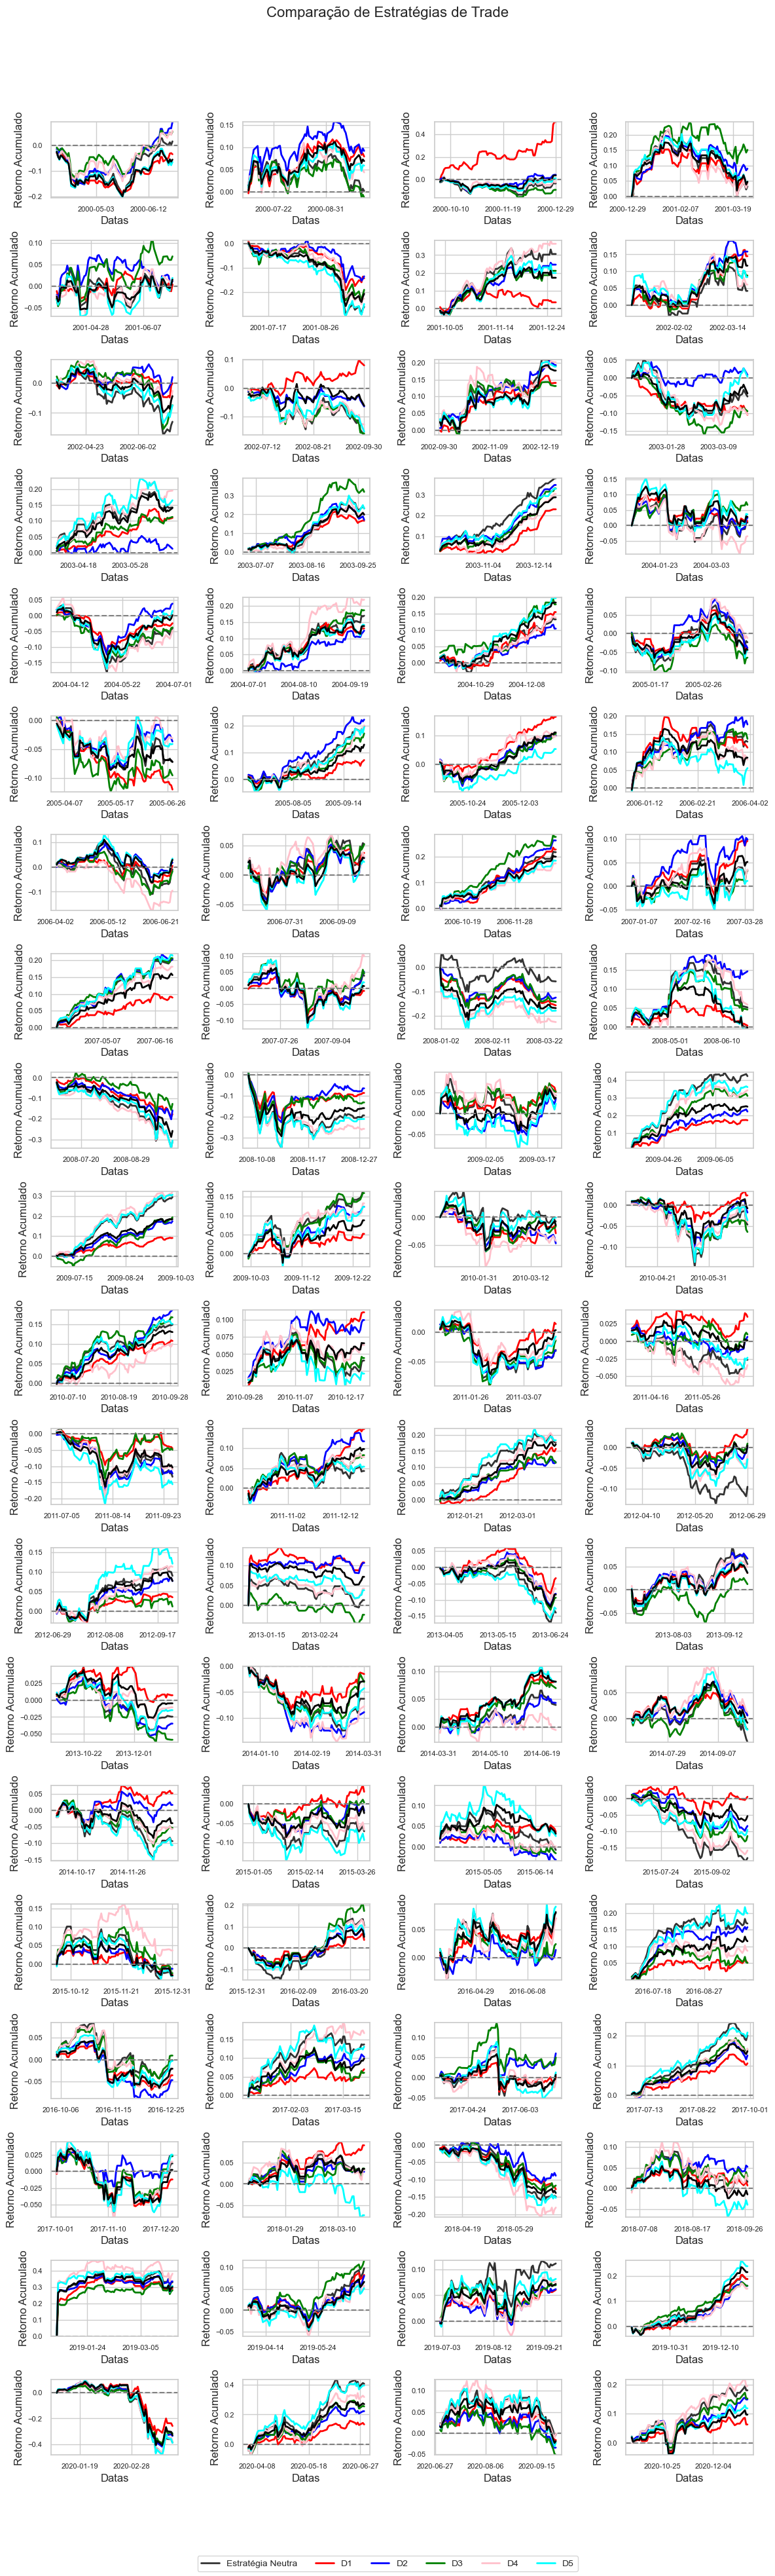

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.set(style='whitegrid')
rows = 20
cols = 4
fig_width = cols * 3  # 2 inches por subplot na largura
fig_height = rows * 2 # 2 inches por subplot na altura
fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

# Configurando o layout do gráfico

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(lista_trade_neutro):
        break
    ax.plot(lista_trade_neutro[i]['Datas'], lista_trade_neutro[i]['Ret_Acumulado_Carteira'], label='Estratégia Neutra', color='black', linewidth=2, alpha=0.8)
    ax.plot(lista_trade_1[i]['Datas'], lista_trade_1[i]['Ret_Acumulado_Carteira'], label='D1', color='red', linewidth=2)
    ax.plot(lista_trade_2[i]['Datas'], lista_trade_2[i]['Ret_Acumulado_Carteira'], label='D2', color='blue', linewidth=2)
    ax.plot(lista_trade_3[i]['Datas'], lista_trade_3[i]['Ret_Acumulado_Carteira'], label='D3', color='green', linewidth=2)
    ax.plot(lista_trade_4[i]['Datas'], lista_trade_4[i]['Ret_Acumulado_Carteira'], label='D4', color='pink', linewidth=2)
    ax.plot(lista_trade_5[i]['Datas'], lista_trade_5[i]['Ret_Acumulado_Carteira'], label='D5', color='cyan', linewidth=2)
    ax.plot(lista_trade_low[i]['Datas'], lista_trade_low[i]['Ret_Acumulado_Carteira'], label='Fator Vol', color='black', linewidth=2)
    
    
    ax.set_xlabel('Datas', fontsize=12)
    ax.set_ylabel('Retorno Acumulado', fontsize=12)
    ax.axhline(y=0, color='grey', linestyle='--')
    
    y_min = min([min(dataset['Ret_Acumulado_Carteira']) for dataset in [lista_trade_neutro[i], lista_trade_1[i], lista_trade_2[i], lista_trade_3[i], lista_trade_4[i], lista_trade_5[i]]])  # Adicione todos os datasets
    y_max = max([max(dataset['Ret_Acumulado_Carteira']) for dataset in [lista_trade_neutro[i], lista_trade_1[i], lista_trade_2[i], lista_trade_3[i], lista_trade_4[i], lista_trade_5[i]]])  # Adicione todos os datasets
    ax.set_ylim([y_min, y_max])
    
    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.figlegend(['Estratégia Neutra', 'D1', 'D2', 'D3', 'D4', 'D5'], loc='lower center', ncol=6, labelspacing=0., fontsize=10)
plt.suptitle("Comparação de Estratégias de Trade", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
    

In [32]:
port_trade_neutro = pd.concat(lista_trade_neutro)
port_trade_neutro['Ret_Acumulado_Carteira'] = (1 + port_trade_neutro['Retorno_Carteira']).cumprod() - 1

port_trade_1 = pd.concat(lista_trade_1)
port_trade_1['Ret_Acumulado_Carteira'] = (1 + port_trade_1['Retorno_Carteira']).cumprod() - 1

port_trade_2 = pd.concat(lista_trade_2)
port_trade_2['Ret_Acumulado_Carteira'] = (1 + port_trade_2['Retorno_Carteira']).cumprod() - 1

port_trade_3 = pd.concat(lista_trade_3)
port_trade_3['Ret_Acumulado_Carteira'] = (1 + port_trade_3['Retorno_Carteira']).cumprod() - 1

port_trade_4 = pd.concat(lista_trade_4)
port_trade_4['Ret_Acumulado_Carteira'] = (1 + port_trade_4['Retorno_Carteira']).cumprod() - 1

port_trade_5 = pd.concat(lista_trade_5)
port_trade_5['Ret_Acumulado_Carteira'] = (1 + port_trade_5['Retorno_Carteira']).cumprod() - 1

port_trade_low = pd.concat(lista_trade_low)
port_trade_low['Ret_Acumulado_Carteira'] = (1 + port_trade_low['Retorno_Carteira']).cumprod() - 1

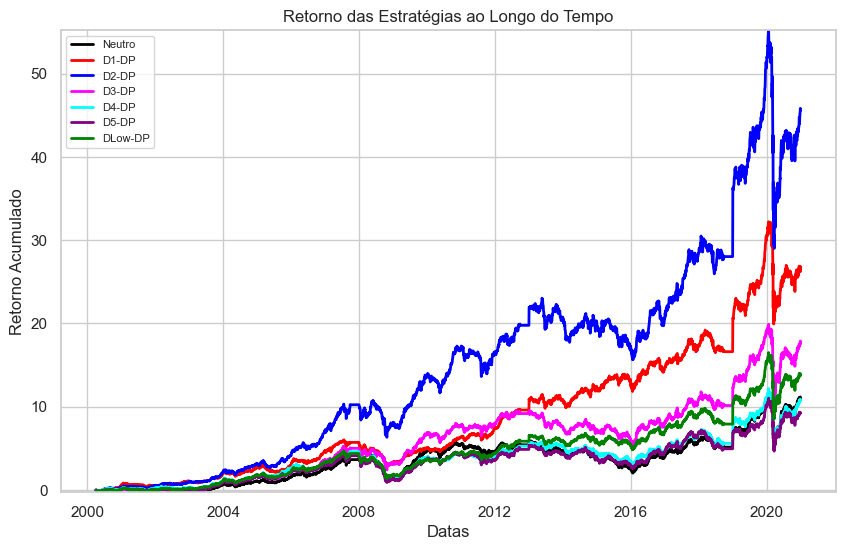

In [33]:
plt.figure(figsize=(10, 6))

# Plotando as linhas para cada conjunto de dados
plt.plot(port_trade_neutro['Datas'], port_trade_neutro['Ret_Acumulado_Carteira'], label='Neutro', color='black', linewidth=2)
plt.plot(port_trade_1['Datas'], port_trade_1['Ret_Acumulado_Carteira'], label='D1-DP', color='red', linewidth=2)
plt.plot(port_trade_2['Datas'], port_trade_2['Ret_Acumulado_Carteira'], label='D2-DP', color='blue', linewidth=2)
plt.plot(port_trade_3['Datas'], port_trade_3['Ret_Acumulado_Carteira'], label='D3-DP', color='magenta', linewidth=2)
plt.plot(port_trade_4['Datas'], port_trade_4['Ret_Acumulado_Carteira'], label='D4-DP', color='cyan', linewidth=2)
plt.plot(port_trade_5['Datas'], port_trade_5['Ret_Acumulado_Carteira'], label='D5-DP', color='purple', linewidth=2)
plt.plot(port_trade_low['Datas'], port_trade_low['Ret_Acumulado_Carteira'], label='DLow-DP', color='green', linewidth=2)


# Configurando os limites do eixo y
y_min = min([port_trade_neutro['Ret_Acumulado_Carteira'].min(), port_trade_1['Ret_Acumulado_Carteira'].min(),
             port_trade_2['Ret_Acumulado_Carteira'].min(), port_trade_3['Ret_Acumulado_Carteira'].min(),
             port_trade_4['Ret_Acumulado_Carteira'].min(), port_trade_5['Ret_Acumulado_Carteira'].min()])

y_max = max([port_trade_neutro['Ret_Acumulado_Carteira'].max(), port_trade_1['Ret_Acumulado_Carteira'].max(),
             port_trade_2['Ret_Acumulado_Carteira'].max(), port_trade_3['Ret_Acumulado_Carteira'].max(),
             port_trade_4['Ret_Acumulado_Carteira'].max(), port_trade_5['Ret_Acumulado_Carteira'].max()])

plt.ylim([y_min, y_max])

# Adicionando rótulos e título
plt.xlabel('Datas')
plt.ylabel('Retorno Acumulado')
plt.title('Retorno das Estratégias ao Longo do Tempo')

# Adicionando uma grade de fundo
plt.grid(True)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
# Creating the Data_DF_Final DataFrame
Data_DF_Final = pd.DataFrame({
    'Datas': port_trade_1['Datas'],
    'Trade1': port_trade_1['Retorno_Carteira'],
    'Trade2': port_trade_2['Retorno_Carteira'],
    'Trade3': port_trade_3['Retorno_Carteira'],
    'Trade4': port_trade_4['Retorno_Carteira'],
    'Trade5': port_trade_5['Retorno_Carteira'],
    'Neutro': port_trade_neutro['Retorno_Carteira']
})

# Creating time series
xts_Trade1 = pd.Series(port_trade_1['Retorno_Carteira'].values, index=port_trade_1['Datas'])
xts_Trade2 = pd.Series(port_trade_2['Retorno_Carteira'].values, index=port_trade_2['Datas'])
xts_Trade3 = pd.Series(port_trade_3['Retorno_Carteira'].values, index=port_trade_3['Datas'])
xts_Trade4 = pd.Series(port_trade_4['Retorno_Carteira'].values, index=port_trade_4['Datas'])
xts_Trade5 = pd.Series(port_trade_5['Retorno_Carteira'].values, index=port_trade_5['Datas'])
xts_TradeLow = pd.Series(port_trade_low['Retorno_Carteira'].values, index=port_trade_low['Datas'])
xts_TradeNeutro = pd.Series(port_trade_neutro['Retorno_Carteira'].values, index=port_trade_neutro['Datas'])
xts_Ibov = pd.Series(ibovespa['Retorno'].values, index=ibovespa['Datas'])

In [35]:
xts_vector = pd.concat([xts_Trade1, xts_Trade2, xts_Trade3, xts_Trade4, xts_Trade5, xts_TradeLow,
                        xts_TradeNeutro, xts_Ibov], axis=1)

# Filtrando os dados para datas após 31/12/2000
xts_vector = xts_vector[xts_vector.index > "2000-12-31"]
xts_vector.columns = ['D1', 'D2', 'D3', 'D4', 'D5', 'DLow', 'Neutro', 'Ibovespa']

In [36]:
xts_vector.fillna(0, inplace=True)

In [37]:
import scipy.stats as stats

def semi_deviation(returns):
    return np.std(returns[returns < 0])

def gain_deviation(returns):
    return np.std(returns[returns > 0])

def loss_deviation(returns):
    return np.std(np.abs(returns[returns < 0]))

def downside_deviation(returns, mar=0):
    return np.sqrt(np.mean(np.minimum(0, returns - mar)**2))

def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

def historical_var(returns, confidence_level=0.95):
    if isinstance(returns, pd.DataFrame):
        return returns.quantile(1 - confidence_level)
    else:
        return np.percentile(returns, 100 * (1 - confidence_level))

def historical_es(returns, confidence_level=0.95):
    var = historical_var(returns, confidence_level)
    return returns[returns <= var].mean()

def modified_var(returns, confidence_level=0.95):
    z = stats.norm.ppf(1 - confidence_level)
    return -np.mean(returns) - z * stats.kurtosis(returns)**0.5

def modified_es(returns, confidence_level=0.95):
    var = modified_var(returns, confidence_level)
    return returns[returns <= var].mean()

# Calculando as métricas de risco para cada série temporal no dataframe de trades
metrics = { 'Semi Deviation': semi_deviation,
    'Gain Deviation': gain_deviation,
    'Loss Deviation': loss_deviation,
    'Downside Deviation (Rf=0%)': lambda x: downside_deviation(x, mar=0),    
    'Maximum Drawdown': max_drawdown,
    'Historical VaR (95%)': lambda x: historical_var(x, confidence_level=0.95),
    'Historical ES (95%)': lambda x: historical_es(x, confidence_level=0.95)
#     'Modified VaR (95%)': lambda x: modified_var(x, confidence_level=0.95),
#     'Modified ES (95%)': lambda x: modified_es(x, confidence_level=0.95)
}

# Criando um dataframe para as métricas
risk_metrics_df = pd.DataFrame({metric: xts_vector.apply(func) for metric, func in metrics.items()})

# Transpondo o dataframe para o formato de dados correto
risk_metrics_df = risk_metrics_df.T

In [38]:
risk_metrics_df

,D1,D2,D3,D4,D5,DLow,Neutro,Ibovespa
Semi Deviation,0.008329,0.009575,0.010069,0.011771,0.012336,0.010309,0.012058,0.012931
Gain Deviation,0.008071,0.009570,0.009595,0.011789,0.012420,0.009956,0.011217,0.012173
Loss Deviation,0.008329,0.009575,0.010069,0.011771,0.012336,0.010309,0.012058,0.012931
Downside Deviation (Rf=0%),0.007075,0.008206,0.009009,0.010356,0.011016,0.008849,0.010475,0.012305
Maximum Drawdown,-0.475063,-0.466155,-0.456016,-0.628705,-0.654083,-0.588266,-0.598070,-0.599611
Historical VaR (95%),-0.013685,-0.016135,-0.019056,-0.021495,-0.022572,-0.017626,-0.021887,-0.026998
Historical ES (95%),-0.022910,-0.026421,-0.029688,-0.033951,-0.036098,-0.029032,-0.034477,-0.039980


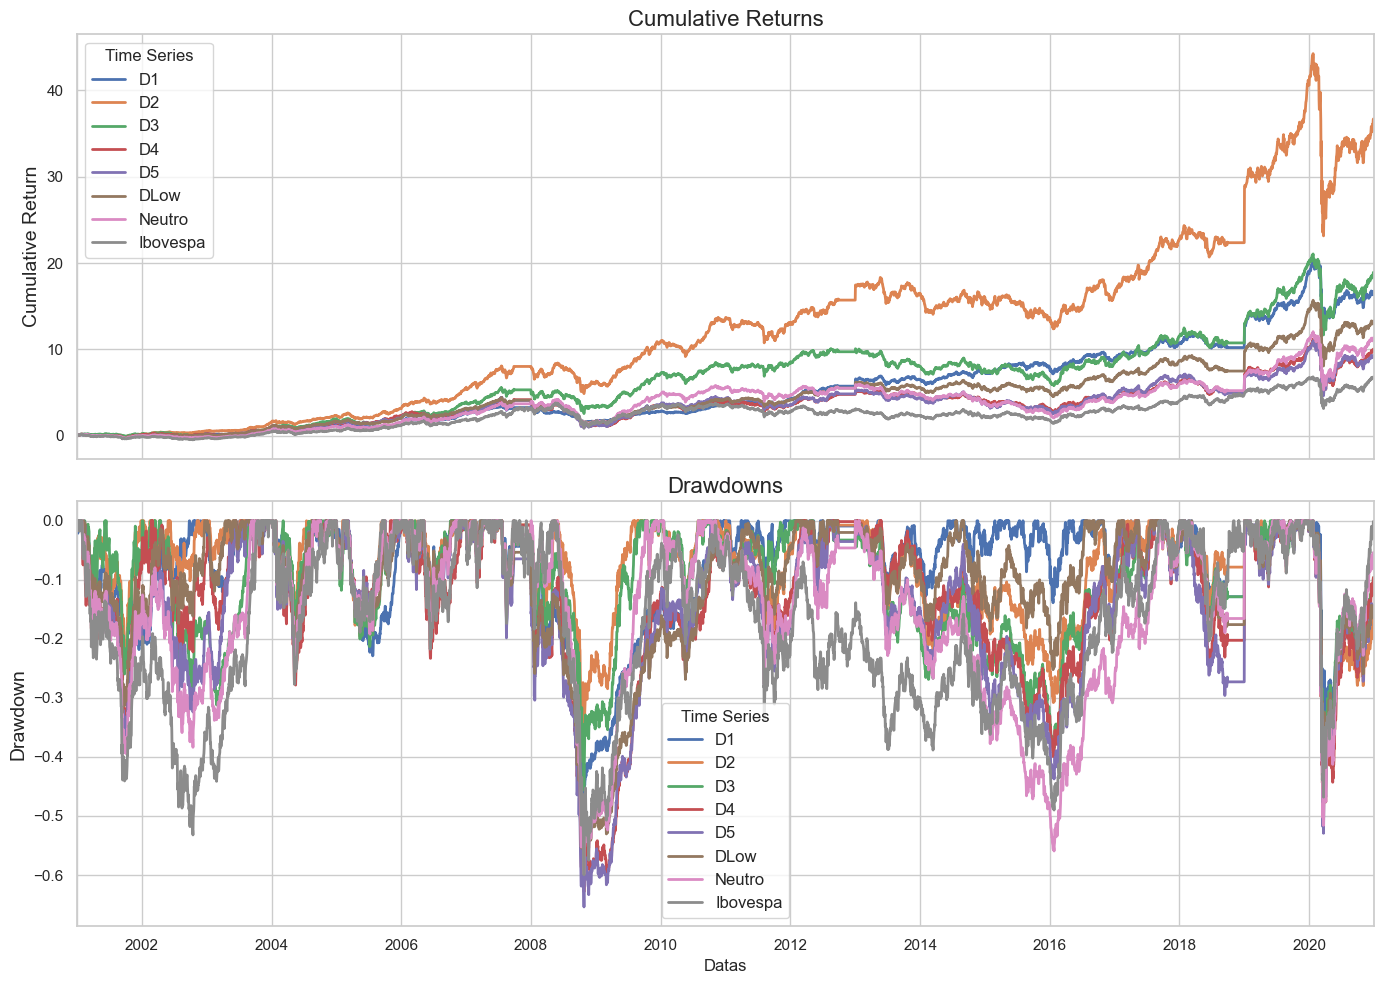

In [39]:
def cumulative_returns(returns):
    """Calcula o retorno acumulado de uma série de retornos."""
    return (1 + returns).cumprod() - 1

def drawdowns(returns):
    """Calcula o drawdown."""
    cumulative = (1 + returns).cumprod()
    max_cumulative = cumulative.cummax()
    return (cumulative - max_cumulative) / max_cumulative

def plot_performance_summary(returns):
    """
    Plotando o resumo de performance incluindo retorno acumulado e drawdowns
    
    :param returns_df: DataFrame of returns
    """
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Retorno Acumulado
    cum_returns_df = returns.apply(cumulative_returns)
    cum_returns_df.plot(ax=axes[0], linewidth=2)
    axes[0].set_title('Cumulative Returns', fontsize=16)
    axes[0].set_ylabel('Cumulative Return', fontsize=14)
    axes[0].legend(title='Time Series', fontsize=12)

    # Drawdowns
    drawdowns_df = returns.apply(drawdowns)
    drawdowns_df.plot(ax=axes[1], linewidth=2)
    axes[1].set_title('Drawdowns', fontsize=16)
    axes[1].set_ylabel('Drawdown', fontsize=14)
    axes[1].legend(title='Time Series', fontsize=12)

    # Setando o layout 
    plt.tight_layout()
    plt.show()

plot_performance_summary(xts_vector)

In [40]:
def annualized_return(returns):
    """Calcula o retorno anualizado de uma série de retornos."""
    compounded_return = np.prod(1 + returns) ** (1 / len(returns)) - 1
    return (1 + compounded_return) ** 252 - 1  # 252 trading days in a year

def annualized_std_dev(returns):
    """Calcula o desvio padrão anualizado de uma série de retornos."""
    return np.std(returns) * np.sqrt(252)

def annualized_sharpe_ratio(returns, risk_free_rate=0):
    """Calcula o Índice Sharpe de uma série de retornos"""
    excess_return = annualized_return(returns) - risk_free_rate
    return excess_return / annualized_std_dev(returns)

# Calculando as métricas para cada série temporal no dataframe
annualized_metrics = {
    'Annualized Return': lambda x: annualized_return(x),
    'Annualized Std Dev': lambda x: annualized_std_dev(x),
    'Annualized Sharpe (Rf=0%)': lambda x: annualized_sharpe_ratio(x)
}

# Criando um dataframe para as metricas anualizadas
annualized_metrics_df = pd.DataFrame({metric: xts_vector.apply(func) for metric, func in annualized_metrics.items()})

# Transpondo o dataframe para o formato de dados correto
annualized_metrics_df = annualized_metrics_df.T

In [41]:
annualized_metrics_df

,D1,D2,D3,D4,D5,DLow,Neutro,Ibovespa
Annualized Return,0.147782,0.191211,0.154488,0.121883,0.118673,0.136227,0.128466,0.104268
Annualized Std Dev,0.164724,0.193678,0.207286,0.239572,0.254735,0.203995,0.237724,0.278269
Annualized Sharpe (Rf=0%),0.897149,0.987266,0.745289,0.508753,0.465870,0.667793,0.540399,0.374701


<Figure size 1600x1000 with 0 Axes>

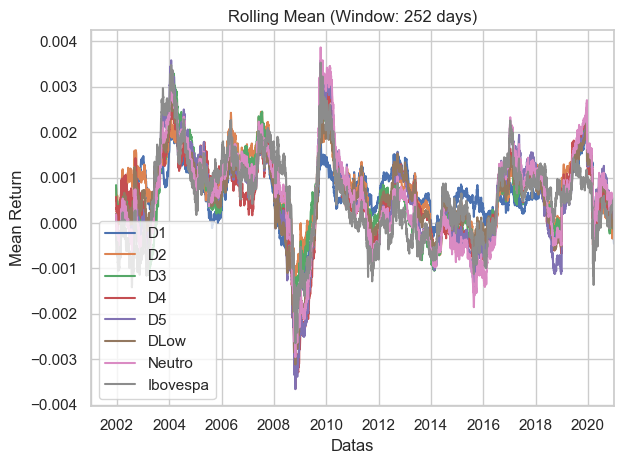

In [42]:
def plot_rolling_performance(returns_df, window=252, title='Rolling Performance'):
    """
    Plot rolling performance metrics for a DataFrame of returns.
    
    :param returns_df: DataFrame of returns
    :param window: Rolling window size (in days)
    :param title: Chart title
    """
    rolling_mean = returns_df.rolling(window=window).mean()

    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(16,10))

    rolling_mean.plot(title=f'Rolling Mean (Window: {window} days)')
    plt.ylabel('Mean Return')
    plt.tight_layout()
    plt.show()


plot_rolling_performance(xts_vector, window=252)

In [43]:
ret_sq = xts_vector ** 2
lambda_ = 0.95
EWMA_Estimado = ret_sq.ewm(span=(2/(1-lambda_)), adjust=False).mean()

In [44]:
Mov_SD = xts_vector.rolling(window=252, min_periods=1).std()

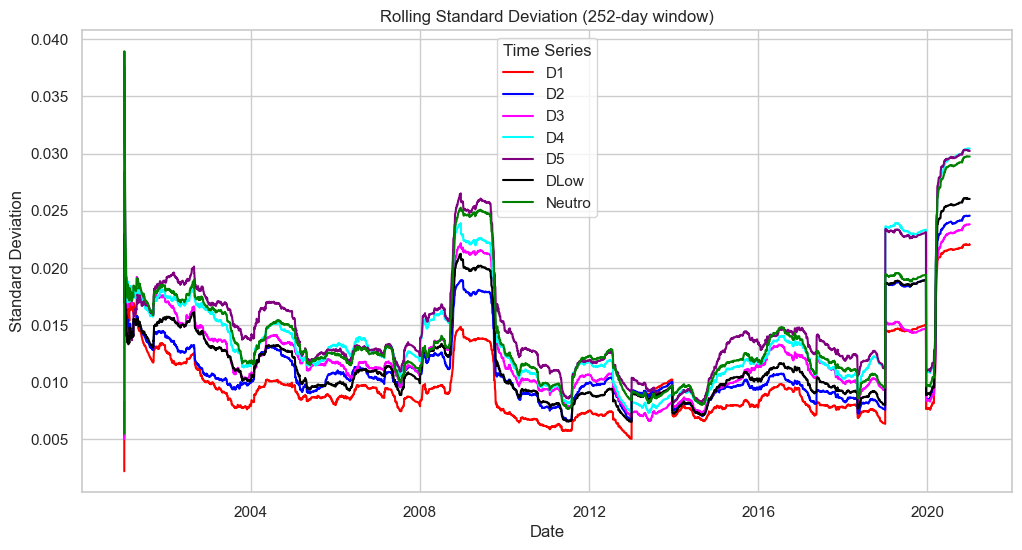

In [45]:
colors = ["red", "blue", "magenta", "cyan", "purple", "black", "green"]

plt.figure(figsize=(12, 6))
for col, color in zip(Mov_SD.columns, colors):
    plt.plot(Mov_SD.index, Mov_SD[col], label=col, color=color)

plt.title('Rolling Standard Deviation (252-day window)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend(title='Time Series')
plt.show()

In [47]:
import pandas as pd
from openpyxl import load_workbook

# Caminhos para os arquivos Excel
paths = ["C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira_Neutra_Trimestral.xlsx",
         "C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira1_Trimestral.xlsx",
         "C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira2_Trimestral.xlsx",
         "C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira3_Trimestral.xlsx",
         "C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira4_Trimestral.xlsx",
         "C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira5_Trimestral.xlsx",
         "C:/Users/Andre/Documents/LowVolatility/Carteiras/Carteira6_Trimestral.xlsx"]
            
anos = range(2000, 2021)

# Substitua 'Lista_Carteira_Mercado', 'Lista_Carteira_1', etc., pelos seus dados
listas_carteiras = [Lista_Carteira_Mercado, lista_carteira_1, lista_carteira_2, lista_carteira_3, lista_carteira_4, lista_carteira_5, lista_carteira_low]

def salvar_carteira_em_excel(lista_carteira, path):
    with pd.ExcelWriter(path, engine='openpyxl') as writer:
        for i, ano in enumerate(anos):
            df = pd.DataFrame(lista_carteira[i])  # Supondo que cada item da lista é um DataFrame
            df.to_excel(writer, sheet_name=str(ano), index=False)

for lista, path in zip(listas_carteiras, paths):
    salvar_carteira_em_excel(lista, path)
